### 자동 섹터 나누기
- 최근 N일간의 주가 데이터(OHLC)를 비슷한 패턴 별로 클러스터링함
- time series를 다루는 tslearn 라이브러리의 k-means 모듈을 사용함

In [1]:
import sys
sys.path.append('..')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.cluster import KMeans
%matplotlib inline

In [134]:
from tslearn.clustering import TimeSeriesKMeans, GlobalAlignmentKernelKMeans
from tslearn.utils import to_time_series

In [4]:
from market import Instruments
from tools import bar_chart

In [124]:
instruments = Instruments.get(is_tradable=True, has_history=True)

In [6]:
# 모든 데이터값을 0~1 사이로 normalize 
def scaler(arr):
    return (arr-arr.min())/(arr.max()-arr.min())

In [166]:
# 패턴 사이즈 (최근거래일)
WINDOW = 40

In [115]:
# 그래프 그리기용도 컬러맵
cm = [color for color in mcolors.cnames.keys() if ('white' not in color) and ('light' not in color)\
     and ('grey' not in color) and ('lime' not in color)] 

In [167]:
arr = []
for a in instruments:
    b = a.history(start=WINDOW)[:,1:5]
    arr.append(scaler(b))
arr = np.array(arr)

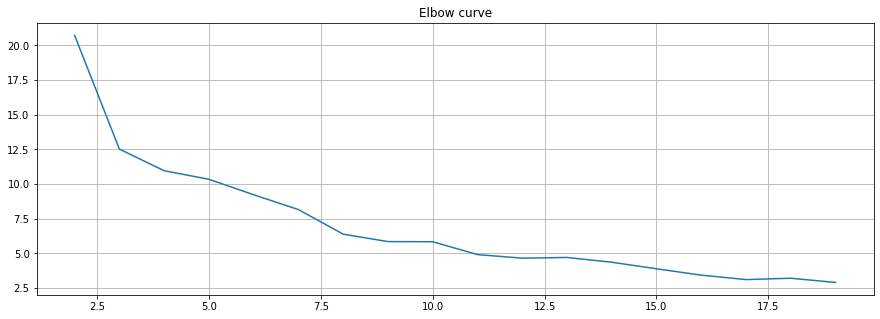

In [143]:
# 섹터 수에 따른 평균 euclidean distance (최적화)
distorsions = []
for k in range(2, 20):
    km = TimeSeriesKMeans(n_clusters=k, max_iter=300).fit(arr)
    distorsions.append(km.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distorsions)
plt.grid(True)
plt.title('Elbow curve')
plt.show()

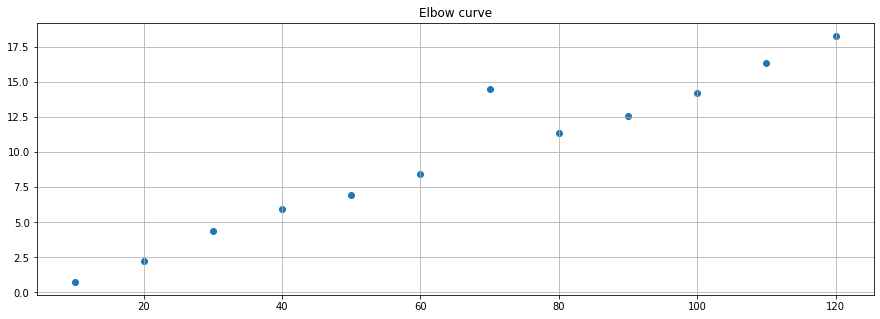

In [144]:
# 윈도우 에 따른 평균 euclidean distance (최적화)
distorsions = []
windows = [10,20,30,40,50,60,70,80,90,100,110,120]
for window in windows:
    arr = []
    for a in instruments:
        b = a.history(start=window)[:,1:5]
        arr.append(scaler(b))
    arr = np.array(arr)
    km = TimeSeriesKMeans(n_clusters=2, max_iter=300).fit(arr)
    distorsions.append(km.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.scatter(windows, distorsions)
plt.grid(True)
plt.title('Elbow curve')
plt.show()

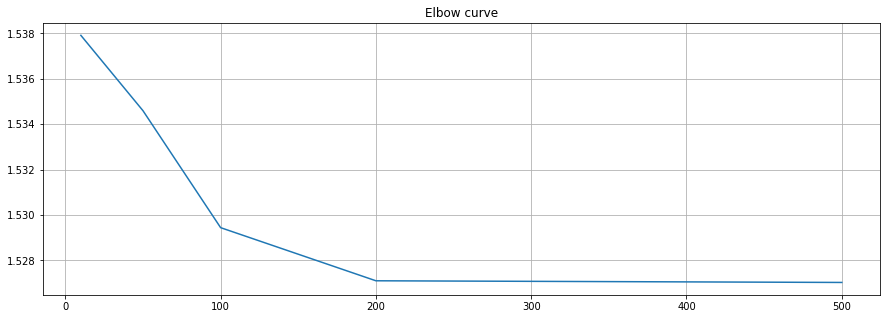

In [192]:
# init value에 따른 평균 euclidean distance (최적화)
distorsions = []
inits = [10,50,100,200,500]
for k in inits:
    km = TimeSeriesKMeans(n_clusters=8,n_init=k, max_iter=300).fit(arr)
    distorsions.append(km.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(inits, distorsions)
plt.grid(True)
plt.title('Elbow curve')
plt.show()

In [193]:
km = TimeSeriesKMeans(n_clusters=8, n_init=200, max_iter=300).fit(arr)

In [194]:
km.labels_

array([2, 2, 5, 3, 4, 2, 2, 3, 4, 5, 6, 0, 4, 0, 0, 1, 1, 6, 1, 1, 1, 7,
       7, 5, 7, 3, 7, 0, 0, 2, 2, 0, 4, 3, 3, 1, 3, 2, 4, 0, 7, 4, 5, 3,
       7, 0, 6, 1, 1, 6, 3, 0], dtype=int64)

In [195]:
nins = np.array(instruments)
sectors = [nins[np.where(km.labels_ == i)[0]].tolist() for i in range(8)]

In [196]:
sectors

[[s&p 500 index e-mini(es),
  dax(fdax),
  euro stoxx 50 index(fesx),
  s&p 400 midcap index(md),
  mexican peso(mp),
  nikkei 225(nk),
  russell 2000 index mini(rty),
  s&p 500 index(sp),
  e-mini dow jones(ym)],
 [euro-bund(fgbl),
  euro-bobl(fgbm),
  euro-oat(foat),
  5-year us treasury note(fv),
  gold(gc),
  palladium(pa),
  10-year us treasury note(ty),
  30-year us treasury bond(us)],
 [australian dollar(ad),
  soybean oil(bo),
  canadian dollar(cd),
  wti crude oil(cl),
  new zealand dollar nzd(ne),
  natural gas(ng),
  gasoline(rb)],
 [corn(c),
  cotton(ct),
  live cattle(lc),
  oats(o),
  orange juice(oj),
  platinum(pl),
  silver(si),
  wheat(w)],
 [cocoa(cc),
  us dollar index(dx),
  euro-btp(fbtp),
  nasdaq 100 index mini(nq),
  rough rice(rr),
  sugar no. 11(sb)],
 [british pound(bp), euro fx(ec), japanese yen(jy), swiss franc chf(sf)],
 [eurodollar(ed),
  euro-schatz(fgbs),
  2-year us treasury note(tu),
  vix futures(vx)],
 [copper(hg),
  heating oil(ho),
  coffee c(kc)

C:\python\python37\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


euro-bund -- euro-bobl -- euro-oat -- 5-year us treasury note -- gold -- palladium -- 10-year us treasury note -- 30-year us treasury bond -- 

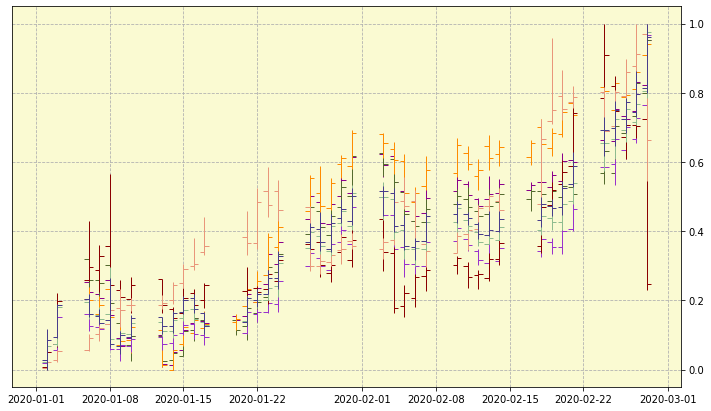

In [185]:
sector = sectors[4]
temp = []
for instrument in sector:
    df = instrument.to_df(start=WINDOW)[['open','high','low','close']]
    mini = df.min().min()
    maxi = df.max().max()
    df = (df-mini)/(maxi-mini)
    temp.append(df)

plt.figure(figsize=(12,7))
for idx, df in enumerate(temp):
    ax = plt.subplot()
    bar_chart(ax, df, colors=[cm[idx+26], cm[idx+26]])
    #ax2 = plt.subplot()
#bar_chart(ax2, instruments[6].to_df(start=10), colors=['r','r'])
for instrument in sector:
    print(instrument.name, end=" -- ")
plt.show()

In [29]:
sectors

[[euro-btp(fbtp),
  euro-bund(fgbl),
  euro-bobl(fgbm),
  euro-schatz(fgbs),
  euro-oat(foat),
  5-year us treasury note(fv),
  rough rice(rr),
  2-year us treasury note(tu),
  10-year us treasury note(ty),
  30-year us treasury bond(us)],
 [australian dollar(ad),
  soybean oil(bo),
  canadian dollar(cd),
  wti crude oil(cl),
  cotton(ct),
  copper(hg),
  heating oil(ho),
  coffee c(kc),
  live cattle(lc),
  lean hogs(ln),
  natural gas(ng),
  gasoline(rb),
  soybeans(s),
  soybean meal(sm)],
 [s&p 400 midcap index(md),
  nikkei 225(nk),
  russell 2000 index mini(rty),
  e-mini dow jones(ym)],
 [euro fx(ec),
  japanese yen(jy),
  new zealand dollar nzd(ne),
  swiss franc chf(sf)],
 [cocoa(cc),
  s&p 500 index e-mini(es),
  dax(fdax),
  euro stoxx 50 index(fesx),
  mexican peso(mp),
  orange juice(oj),
  s&p 500 index(sp)],
 [silver(si)],
 [british pound(bp), corn(c), oats(o), platinum(pl), wheat(w)],
 [us dollar index(dx),
  eurodollar(ed),
  gold(gc),
  nasdaq 100 index mini(nq),
  pa

In [20]:
instrument = Instruments.get(name='cotton')[0]

In [24]:
instruments

[australian dollar(ad),
 soybean oil(bo),
 british pound(bp),
 corn(c),
 cocoa(cc),
 canadian dollar(cd),
 wti crude oil(cl),
 cotton(ct),
 us dollar index(dx),
 euro fx(ec),
 eurodollar(ed),
 s&p 500 index e-mini(es),
 euro-btp(fbtp),
 dax(fdax),
 euro stoxx 50 index(fesx),
 euro-bund(fgbl),
 euro-bobl(fgbm),
 euro-schatz(fgbs),
 euro-oat(foat),
 5-year us treasury note(fv),
 gold(gc),
 copper(hg),
 heating oil(ho),
 japanese yen(jy),
 coffee c(kc),
 live cattle(lc),
 lean hogs(ln),
 s&p 400 midcap index(md),
 mexican peso(mp),
 new zealand dollar nzd(ne),
 natural gas(ng),
 nikkei 225(nk),
 nasdaq 100 index mini(nq),
 oats(o),
 orange juice(oj),
 palladium(pa),
 platinum(pl),
 gasoline(rb),
 rough rice(rr),
 russell 2000 index mini(rty),
 soybeans(s),
 sugar no. 11(sb),
 swiss franc chf(sf),
 silver(si),
 soybean meal(sm),
 s&p 500 index(sp),
 2-year us treasury note(tu),
 10-year us treasury note(ty),
 30-year us treasury bond(us),
 vix futures(vx),
 wheat(w),
 e-mini dow jones(ym)]